# Decision tree and random forest

In [1]:
# libraries
import pandas as pd # process dataframe
import numpy as np # scientific calculation
import matplotlib.pyplot as plt # plot


# model selection and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV # train-test split and grid search
from imblearn.over_sampling import SMOTE # SMOTE
from sklearn.preprocessing import StandardScaler # Scaling
from sklearn.metrics import log_loss, make_scorer # loss

# models
from sklearn import tree # tree based model
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest 

# evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report #confusion matrix

## 1. Dataset spliting

In [2]:
data = pd.read_csv('../dataset/Churn_Modelling_Train.csv')
data = data.drop(columns=['Unnamed: 0', 'CustomerId', 'RowNumber', 'Surname', 'Geography'])

train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Exited'])

train_df = train_df.copy()
test_df = test_df.copy()

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Training set has {len(train_df)} rows')
print(f'Test set has {len(test_df)} rows')

Training set has 5992 rows
Test set has 1499 rows


In [3]:
# proportion of labels in the training set
train_df['Exited'].value_counts(normalize=True)

0    0.836782
1    0.163218
Name: Exited, dtype: float64

In [4]:
# proportion of labels in the test set
test_df['Exited'].value_counts(normalize=True)

0    0.836558
1    0.163442
Name: Exited, dtype: float64

## 2. Training set prep

In [5]:
# categorical encoding for gender
gender_cat = pd.get_dummies(train_df['Gender'])
train_df = pd.concat([train_df.drop(columns=['Gender']), gender_cat], axis=1)

# define x and y train
X_train, y_train = train_df.drop(columns=['Exited']), train_df['Exited']

display(X_train, y_train)

# SMOTE to make both classes balanced 
oversample = SMOTE()
X_train_s, y_train_s = oversample.fit_resample(X_train, y_train)
len(X_train_s)

# Scaling
scaler = StandardScaler()
sc = scaler.fit(X_train_s)
X_train_s = sc.transform(X_train_s)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Female,Male
0,597,33,9,0.00,2,1,0,49374.82,0,1
1,639,35,8,0.00,2,1,0,170483.90,0,1
2,553,31,6,0.00,2,0,0,124596.63,0,1
3,604,36,6,116229.85,2,1,1,79633.38,0,1
4,723,34,5,0.00,2,0,1,12092.03,0,1
...,...,...,...,...,...,...,...,...,...,...
5987,661,48,3,120320.54,1,0,0,96463.25,0,1
5988,632,37,1,138207.08,1,1,0,60778.11,0,1
5989,669,30,7,95128.86,1,0,0,19799.26,0,1
5990,681,37,7,69609.85,1,1,1,72127.83,1,0


0       0
1       0
2       0
3       0
4       0
       ..
5987    0
5988    1
5989    0
5990    0
5991    1
Name: Exited, Length: 5992, dtype: int64

## 3. Test set prep

In [6]:
# categorical encoding for gender
gender_cat = pd.get_dummies(test_df['Gender'])
test_df = pd.concat([test_df.drop(columns=['Gender']), gender_cat], axis=1)

# define x and y train
X_test, y_test = test_df.drop(columns=['Exited']), test_df['Exited']

display(X_test, y_test)

# Scaling
X_test = sc.transform(X_test)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Female,Male
0,759,41,9,0.00,2,0,1,190294.12,0,1
1,682,43,5,125851.93,1,1,1,193318.33,1,0
2,554,26,8,149134.46,1,1,1,177966.24,0,1
3,667,40,8,72945.29,2,1,0,98931.50,0,1
4,782,41,4,0.00,1,1,0,132943.88,1,0
...,...,...,...,...,...,...,...,...,...,...
1494,602,35,5,0.00,2,1,0,31050.02,1,0
1495,610,40,9,0.00,1,1,1,149602.54,0,1
1496,560,31,5,125341.69,1,1,0,79547.39,1,0
1497,752,30,3,0.00,2,1,1,104991.28,1,0


0       0
1       0
2       0
3       0
4       0
       ..
1494    0
1495    0
1496    0
1497    0
1498    0
Name: Exited, Length: 1499, dtype: int64

## 4. Evaluation metric function

In [7]:
def show_evaluation(y_true, y_pred, labels):
    print(classification_report(y_true, y_pred, target_names=labels))
    print()
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

## 5. Models

### 5.1 Baseline model: logistic regression

In [8]:
# load model
lr = LogisticRegression()
cv = 10

# params
grid = dict()
grid['penalty'] = ['l2']
grid['C'] = [10e-4, 10e-3, 10e-2, 10e-1, 1, 10e01, 10e02, 10e03, 10e04]
grid['solver'] = ['lbfgs']
grid['max_iter'] = [20, 50, 100, 200, 500, 1000]
grid['intercept_scaling'] = [None]

# define scoring - log loss
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True, labels=[0, 1])

# features and labels
X, y = X_train_s, y_train_s

# perform the search
search = GridSearchCV(lr, grid, cv=cv, n_jobs=-1, scoring=LogLoss, return_train_score=True)
model_lr = search.fit(X, y)

print(search.best_score_)
print(search.best_params_)

-0.410499301445987
{'C': 1000.0, 'intercept_scaling': None, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}


              precision    recall  f1-score   support

          no       0.80      0.84      0.82      5014
         yes       0.83      0.79      0.81      5014

    accuracy                           0.81     10028
   macro avg       0.81      0.81      0.81     10028
weighted avg       0.81      0.81      0.81     10028




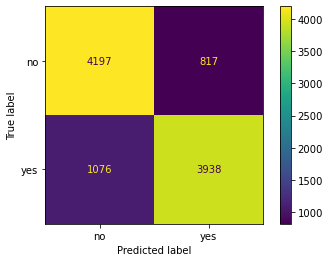

In [9]:
# training set performance
lr_trn_pred = model_lr.predict(X)

show_evaluation(y_true=y, y_pred=lr_trn_pred, labels=['no', 'yes'])

              precision    recall  f1-score   support

          no       0.89      0.84      0.86      1254
         yes       0.36      0.47      0.40       245

    accuracy                           0.78      1499
   macro avg       0.62      0.65      0.63      1499
weighted avg       0.80      0.78      0.79      1499




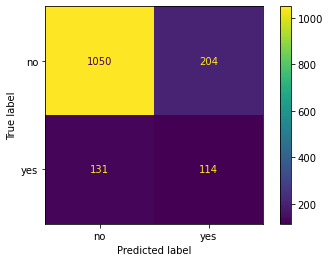

In [10]:
# test set performance
lr_test_pred = model_lr.predict(X_test)

show_evaluation(y_true=y_test, y_pred=lr_test_pred, labels=['no', 'yes'])

### 5.1.1 Baseline model: logistic regression with mean precision as criterion

In [11]:
# load model
lr = LogisticRegression()
cv = 10

# params
grid = dict()
grid['penalty'] = ['l2']
grid['C'] = [10e-4, 10e-3, 10e-2, 10e-1, 1, 10e01, 10e02, 10e03, 10e04]
grid['solver'] = ['lbfgs']
grid['max_iter'] = [20, 50, 100, 200, 500, 1000]
grid['intercept_scaling'] = [None]

# features and labels
X, y = X_train_s, y_train_s

# perform the search
search = GridSearchCV(lr, grid, cv=cv, n_jobs=-1, scoring='average_precision', return_train_score=True)
model_lr_prc = search.fit(X, y)

print(search.best_score_)
print(search.best_params_)

0.9022874330519823
{'C': 100000.0, 'intercept_scaling': None, 'max_iter': 50, 'penalty': 'l2', 'solver': 'lbfgs'}


              precision    recall  f1-score   support

          no       0.80      0.84      0.82      5014
         yes       0.83      0.79      0.81      5014

    accuracy                           0.81     10028
   macro avg       0.81      0.81      0.81     10028
weighted avg       0.81      0.81      0.81     10028




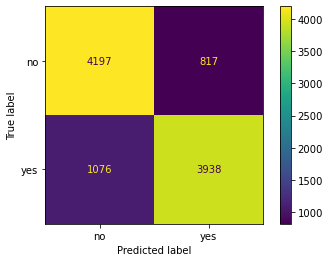

In [12]:
# training set performance
lrprc_trn_pred = model_lr_prc.predict(X)

show_evaluation(y_true=y, y_pred=lrprc_trn_pred, labels=['no', 'yes'])

              precision    recall  f1-score   support

          no       0.89      0.84      0.86      1254
         yes       0.36      0.47      0.40       245

    accuracy                           0.78      1499
   macro avg       0.62      0.65      0.63      1499
weighted avg       0.80      0.78      0.79      1499




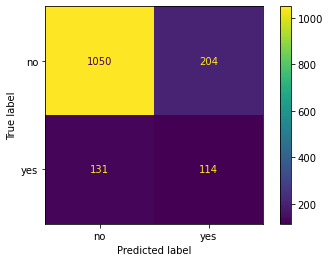

In [13]:
# test set performance
lrprc_test_pred = model_lr_prc.predict(X_test)

show_evaluation(y_true=y_test, y_pred=lrprc_test_pred, labels=['no', 'yes'])

### 5.2 Decision tree

In [14]:
# load model
dt = DecisionTreeClassifier(random_state=42, criterion='gini')
cv = 10

# params
grid = dict()
grid['max_depth'] = [10, 100, 1000]
grid['min_samples_split'] = [2, 4, 6, 8, 10, 100, 1000]

# features and labels
X, y = X_train_s, y_train_s

# perform the search
search = GridSearchCV(dt, grid, cv=cv, n_jobs=-1, scoring='average_precision', return_train_score=True)
model_dt = search.fit(X, y)

print(search.best_score_)
print(search.best_params_)

0.9210924821283666
{'max_depth': 10, 'min_samples_split': 100}


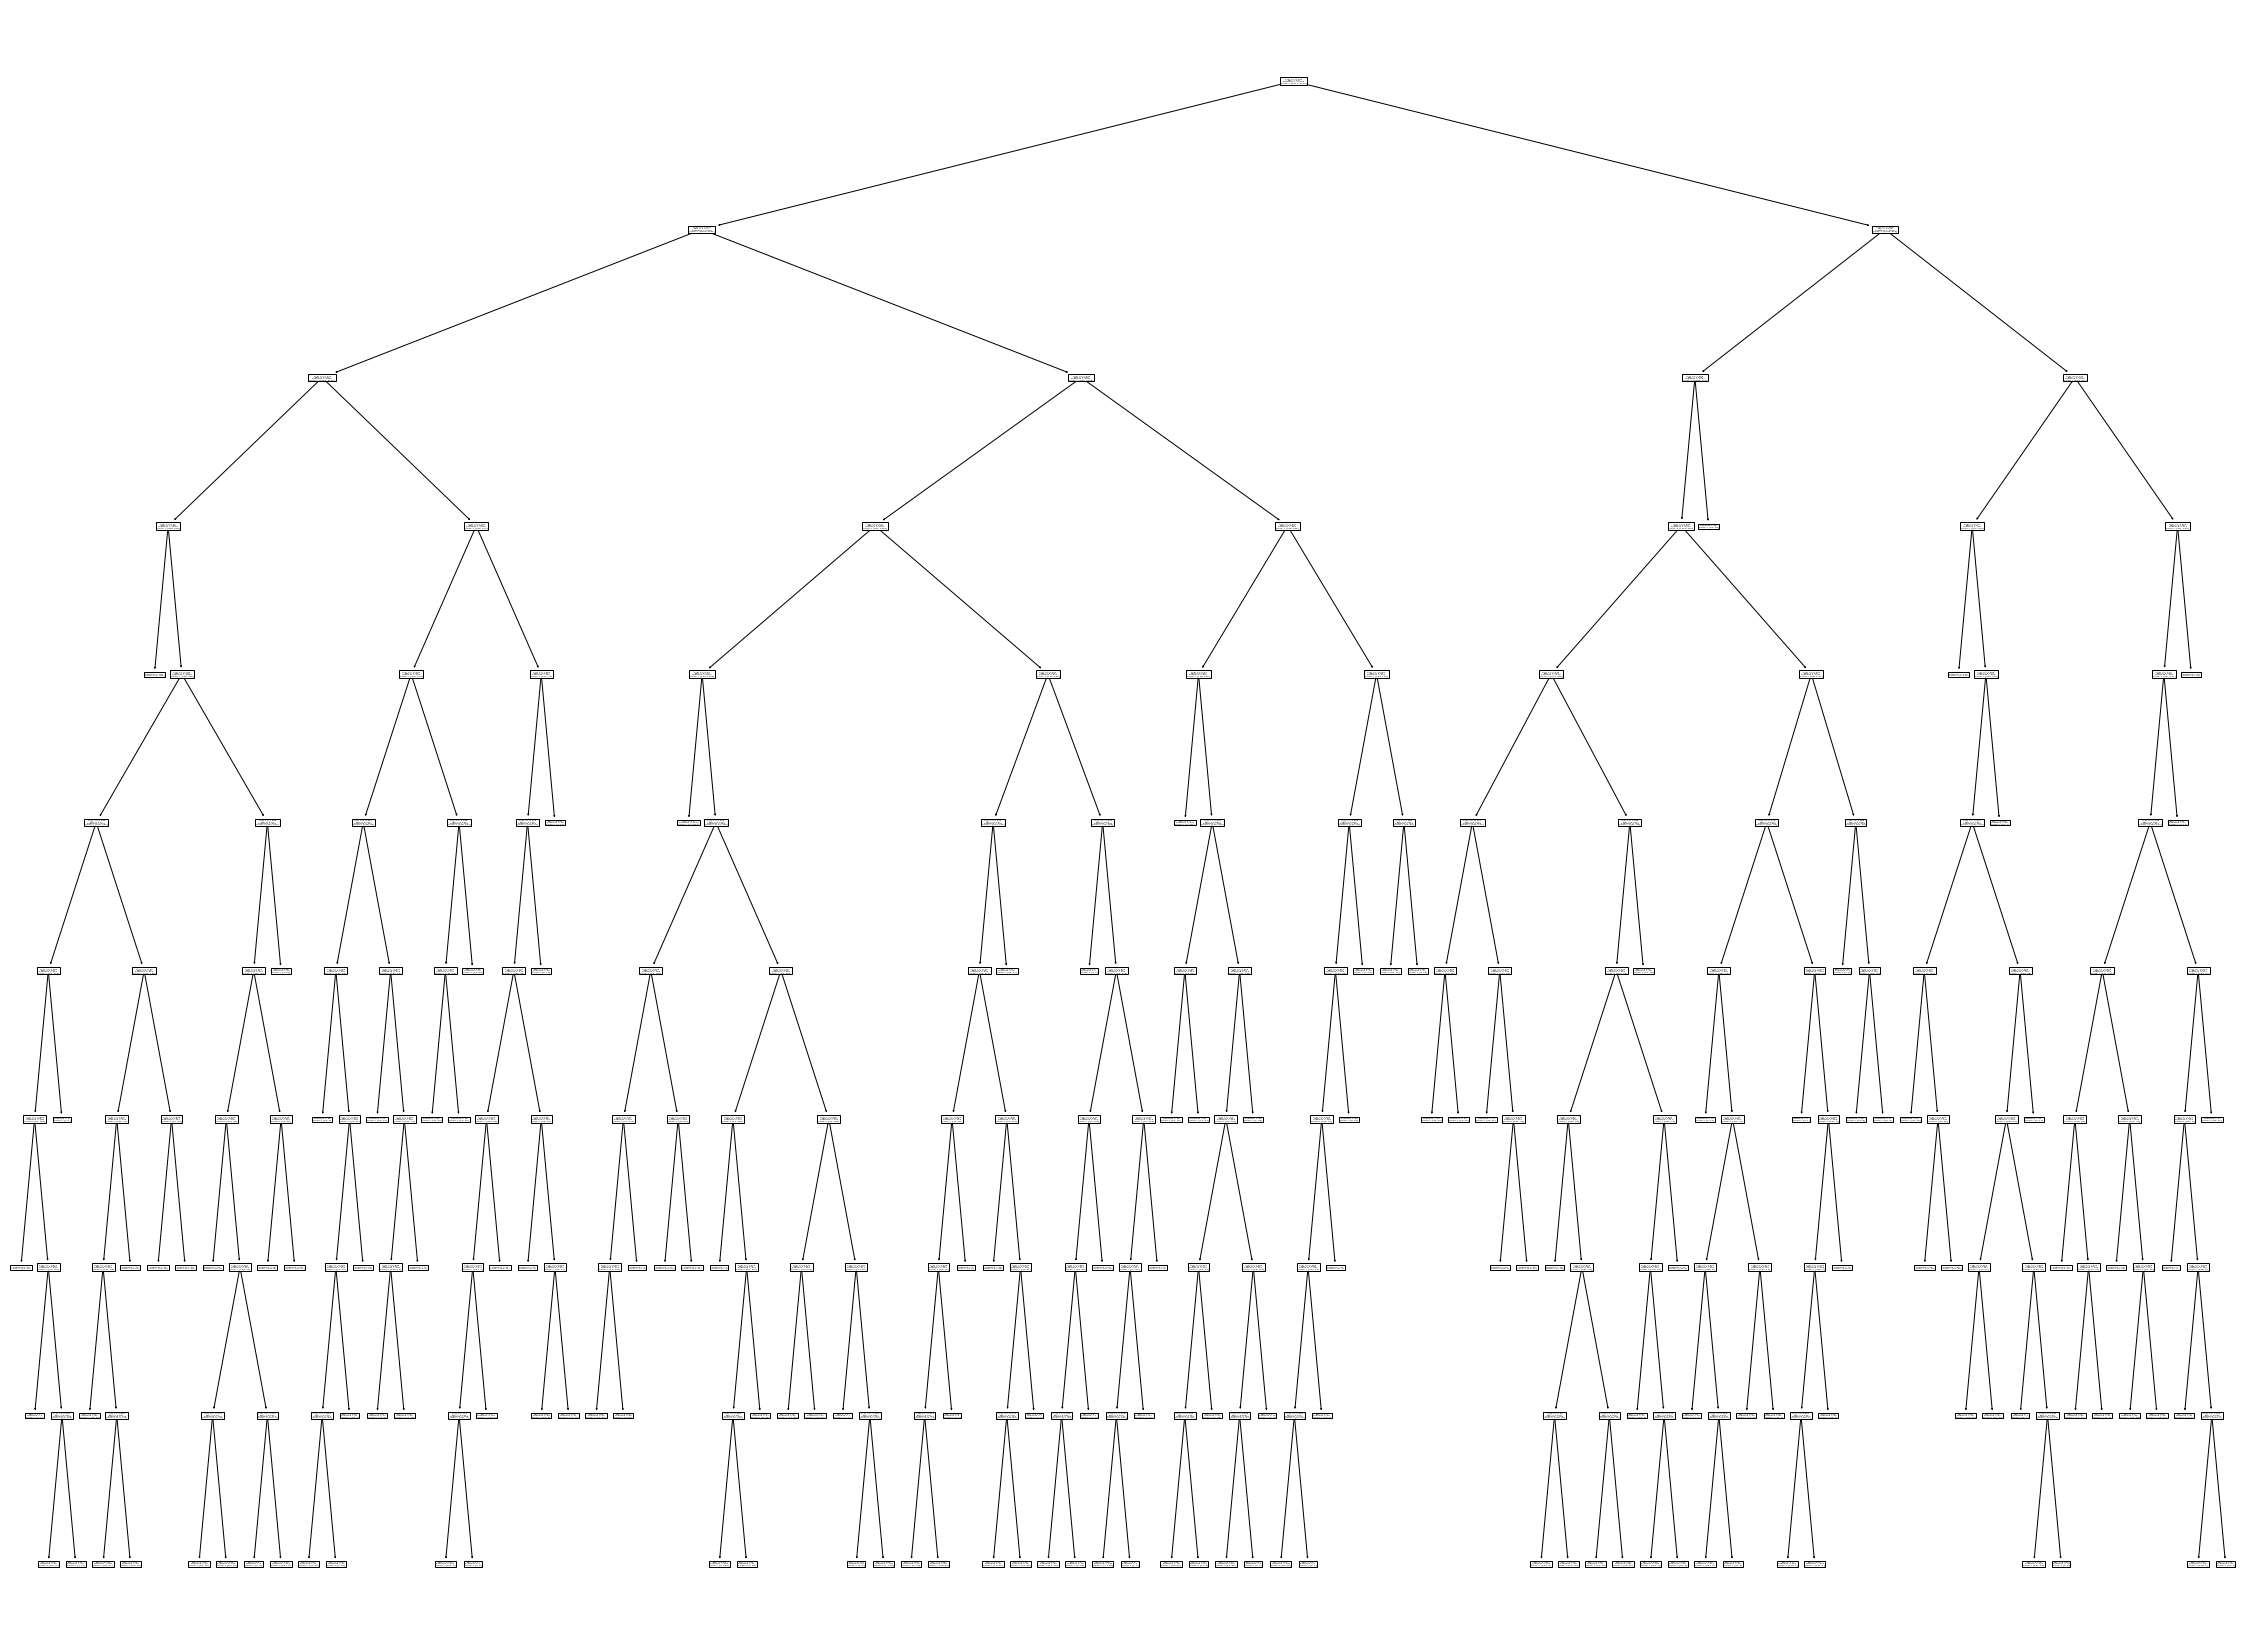

In [15]:
# plot the whole tree
size = plt.figure(figsize=(40, 30))

dt_fit = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=10, min_samples_split=100)
dt_fit = dt_fit.fit(X, y)
tree.plot_tree(dt_fit)
plt.show()

Annotation(0.576208, 0.954545, 'X[6] <= 0.291\ngini = 0.5\nsamples = 10028\nvalue = [5014, 5014]')


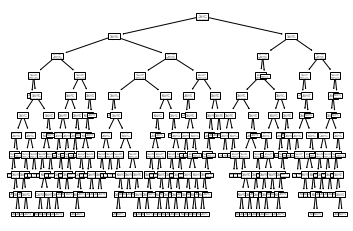

In [16]:
print(tree.plot_tree(dt_fit)[0])

In [17]:
X_train.iloc[:,7]

0        49374.82
1       170483.90
2       124596.63
3        79633.38
4        12092.03
          ...    
5987     96463.25
5988     60778.11
5989     19799.26
5990     72127.83
5991    150694.42
Name: EstimatedSalary, Length: 5992, dtype: float64

In [18]:
# get feature importance
importance = pd.DataFrame({'Feature': X_train.columns, 
                           'Importance Score': dt_fit.feature_importances_}).sort_values(by=['Importance Score'])
importance

,Feature,Importance Score
2,Tenure,0.008291
5,HasCrCard,0.013193
0,CreditScore,0.015755
7,EstimatedSalary,0.037205
3,Balance,0.073113
9,Male,0.088397
4,NumOfProducts,0.099613
8,Female,0.142563
6,IsActiveMember,0.256541
1,Age,0.265329


              precision    recall  f1-score   support

          no       0.86      0.89      0.87      5014
         yes       0.88      0.85      0.87      5014

    accuracy                           0.87     10028
   macro avg       0.87      0.87      0.87     10028
weighted avg       0.87      0.87      0.87     10028




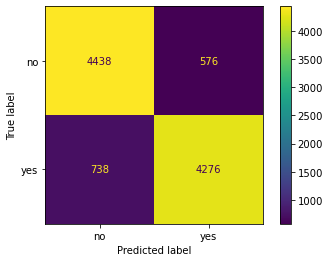

In [19]:
# training set performance
dt_trn_pred = model_dt.predict(X)

show_evaluation(y_true=y, y_pred=dt_trn_pred, labels=['no', 'yes'])

              precision    recall  f1-score   support

          no       0.91      0.86      0.88      1254
         yes       0.44      0.57      0.49       245

    accuracy                           0.81      1499
   macro avg       0.67      0.71      0.69      1499
weighted avg       0.83      0.81      0.82      1499




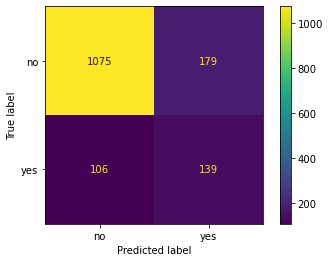

In [20]:
# test set performance
dt_test_pred = model_dt.predict(X_test)

show_evaluation(y_true=y_test, y_pred=dt_test_pred, labels=['no', 'yes'])

### 5.3 Random forest - takes time when running it

In [21]:
# load model
rf = RandomForestClassifier(random_state=42, criterion='gini', n_jobs=-1)
cv = 10

# params
grid = dict()
grid['max_depth'] = [10, 100, 1000]
grid['min_samples_split'] = [2, 4, 6, 8, 10, 100, 1000]
grid['n_estimators'] = [10, 100, 1000]

# features and labels
X, y = X_train_s, y_train_s

# perform the search
search = GridSearchCV(rf, grid, cv=cv, n_jobs=-1, scoring='average_precision', return_train_score=True)
model_rf = search.fit(X, y)

print(search.best_score_)
print(search.best_params_)

0.9614257160870355
{'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 1000}


              precision    recall  f1-score   support

          no       1.00      1.00      1.00      5014
         yes       1.00      1.00      1.00      5014

    accuracy                           1.00     10028
   macro avg       1.00      1.00      1.00     10028
weighted avg       1.00      1.00      1.00     10028




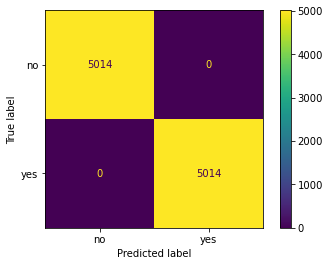

In [22]:
# training set performance
rf_trn_pred = model_rf.predict(X)

show_evaluation(y_true=y, y_pred=rf_trn_pred, labels=['no', 'yes'])

              precision    recall  f1-score   support

          no       0.91      0.91      0.91      1254
         yes       0.54      0.55      0.55       245

    accuracy                           0.85      1499
   macro avg       0.73      0.73      0.73      1499
weighted avg       0.85      0.85      0.85      1499




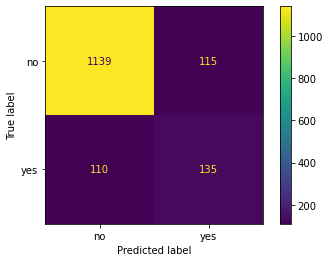

In [23]:
# test set performance
rf_test_pred = model_rf.predict(X_test)

show_evaluation(y_true=y_test, y_pred=rf_test_pred, labels=['no', 'yes'])